# MSc NNs
> Indented block



In [1]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')
path = "/content/drive/MyDrive/msc_final_boss/tests/lopukad/"

Mounted at /content/drive


In [3]:
import pandas as pd
import scipy
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cal_methods_slim
import tqdm

# Neural net


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, metrics, losses, Model
import tensorflow_datasets as tfds
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import tqdm as tqdm
from sklearn.preprocessing import StandardScaler

In [30]:
def rel_diag(bins, data, true, title = "", supress = False, title_save = ""):
    # data on shape = (n, classes)
    #pred = np.argmax(data, axis = 1)
    massimo = data[1]
    #true = np.concatenate((true, true))
    acc = []
    conf = []
    prec_conf = []
    ratios = []
    for i in range(bins):
        selection = (massimo > i/bins) * (massimo <= (i+1)/bins)
        ratio = max([sum(selection),1])
        acc.append(sum(true[selection])/ratio)
        conf.append((i)/bins)
        prec_conf.append(sum(massimo[selection])/ratio)
        ratios.append(sum(selection)/len(massimo))
    #massimo = data.reshape((1,-1))[0]
    subs = abs(np.array(acc) - np.array(prec_conf))
    ece = np.round(sum(subs*np.array(ratios)),3)
    if supress:
        return ece
    #plt.axes(aspect = "equal")
    prec_conf = np.array(prec_conf)
    conf = np.array(conf)
    print(conf, prec_conf)
    #plt.bar(conf, acc, 1/bins, color = "#3c7dc2",ec = "black",lw = 0.5, align = "edge", label = "Mudeli väljund")
    #plt.xlabel("Positiivsesse klassi ennustatud tõenäosus")
    #plt.ylabel("Positiivse klassi osakaal ennustustes")
    #plt.title(title + "Usaldusväärsusdiagramm, kus ECE = %s" % (ece))
    #plt.plot([0,1],[0,1], color = "blue", ls = "--")
    #plt.bar(prec_conf - 1/(bins*6), subs*(acc < prec_conf), 1/(bins*3), acc*(acc < np.linspace(1/bins,1,bins)), align = "edge",color = "pink",alpha = 1, edgecolor = "#ff6666", linestyle = "--", label = "Erinevus")
    #plt.bar(prec_conf - 1/(bins*6), -subs*(acc > prec_conf), 1/(bins*3), acc , color = "pink",edgecolor = "#ff6666",align = "edge", alpha=1, linestyle="--")
    
    #plt.bar(conf, subs, 1/10, acc[acc > np.linspace(1/bins,1,bins)], color = "pink")
    #print(acc,conf)
    plt.bar(conf, acc, 1/bins, color = "#3c7dc2",ec = "black",lw = 0.5, align = "edge", label = "Mudeli väljund", zorder = 0.0)
    plt.xlabel("Positiivsesse klassi ennustatud tõenäosus")
    plt.ylabel("Positiivse klassi osakaal ennustustes")
    plt.title(title + "Usaldusväärsusdiagramm, kus ECE = %s" % (ece))
    plt.plot([0,1],[0,1], color = "blue", ls = "--")
    plt.bar(prec_conf - 1/(bins*6), subs*(acc < prec_conf), 1/(bins*3), acc*(acc < np.linspace(1/bins,1,bins)), align = "edge",color = "pink", edgecolor = "#ff6666", linestyle = "--", label = "Erinevus", zorder = 1.0)
    plt.bar(prec_conf - 1/(bins*6), -subs*(acc > prec_conf) ,1/(bins*3), acc , color = "pink",edgecolor = "#ff6666",align = "edge", linestyle="--", zorder = 1.0)
    plt.scatter(prec_conf[prec_conf!=0], np.array(acc)[prec_conf!=0], marker = "+", alpha = 1,color = "red", zorder= 2.0)
    #plt.bar(conf, subs, 1/10, acc[acc > np.linspace(1/bins,1,bins)], color = "pink", zorder = 1.0)
    #print(acc,conf)
   
    plt.legend()
    if title_save != "":
        plt.savefig(path + "%s.png" % (title_save), dpi = 300)
    plt.show()
    plt.clf()
    return ece

In [7]:
def to_logits(probs):
    logits = np.log(probs)
    return logits

def to_logits_2(probs):
    logits = -np.log(1/probs - 1)
    return logits
    
def sigmoid(X):
    return 1/(1+ np.exp(-X))


In [34]:
def create_model(input, width):
    inp = layers.Input( (input))
    x = layers.Dense(width[0], activation='relu')(inp)
    #x2 = layers.Dense(64, activation="relu")(x)
    #x3 = layers.Dense(32, activation="relu")(x2)
    y = layers.Dense(width[-1])(x)

    return  Model(inputs = inp, outputs = y)

In [35]:
#data
def gen_mc_data(n_feat, infor, N = 21_000, redundant = 0):

  X_train, y_train = make_classification(n_samples=N*10 , n_features = n_feat, n_informative=n_feat, n_redundant=0, n_classes=2, n_clusters_per_class=1 )
  #scaler=StandardScaler()
  #X_train=scaler.fit_transform(X_train) 
  X_val, y_val = X_train[0:100000], y_train[0:100000] 
  X_test, y_test =  X_train[100000:110000], y_train[100000:110000] 
  X_train, y_train = X_train[110000:], y_train[110000:]
  return [X_train, y_train, X_test, y_test, X_val, y_val]

In [36]:
## data generation
def gen_data(n_feat, N = 100_000, eri = False):
  #N = 100000
  epsilon1 = 0#np.array([-0.5,0]) #3:[-0.5,1]; [0.5,-1]
  epsilon2 = 0#np.array([0.5,0])
  
  #n_feat = 100
  ny = 50_000
  nt = 5000
  if eri == True:
    mu_1, mu_2 = np.array([5,1,3,-1,4, 6, 7, 8, 9, -4]), np.array([-5,1,3,-1,4,6, 7, 8, 9, -4])
    sgm = np.identity(10) * np.array([9,1,1,1,1,1,1,1,1,1])
    #sgm = np.array([[4,0,0,0,0],[0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1]])
    #mu_1, mu_2 = np.array([2,0]), np.array([-2,0])
    #sgm = np.array([[1,0],[0,1]])
    #mu_1, mu_2 = 2, -2
    #sgm = 4
    
  else:
    mu_1 = np.random.choice([-1,1], n_feat)
    mu_2 = (-1) * mu_1
    #mu_2 = np.random.choice([-1,1], n_feat)
    sgm = np.identity(n_feat)*(n_feat/3)

  #mu_1, mu_2 = np.array([1,-1]), np.array([-1,1])
  #mu_1, mu_2 = np.random.randint(-5,5, n_feat), np.random.randint(-10,10,n_feat)
  
  #sgm = np.array([[1,0],[0,1]])

  #sgm = np.identity(len(mu_1)) * np.random.randint(1, 50, len(mu_1))

  distr_1 = np.random.multivariate_normal(mu_1 , sgm, N) #negatives
  val_1 =  np.random.multivariate_normal(mu_1 + epsilon1, sgm, ny)
  test_1 = np.random.multivariate_normal(mu_1 + epsilon1, sgm, nt)

  test_2 = np.random.multivariate_normal(mu_2 + epsilon2, sgm, nt)
  val_2 =  np.random.multivariate_normal(mu_2 + epsilon2, sgm, ny) #positives
  distr_2 = np.random.multivariate_normal(mu_2 , sgm, N)


  y_val = np.concatenate((np.zeros(ny), np.ones(ny)))
  y_train = np.concatenate((np.zeros(N),np.ones(N)))
  y_test= np.concatenate((np.zeros(nt), np.ones(nt)))
  X_train = np.concatenate((distr_1,distr_2))
  X_test = np.concatenate((test_1,test_2))
  X_val = np.concatenate((val_1, val_2))
  return [X_train, y_train, X_test, y_test, X_val, y_val]

In [ ]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 

In [ ]:
!apt install cm-super

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


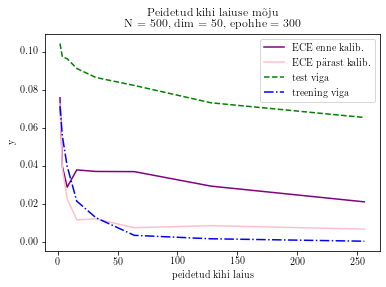

In [14]:
syg = [[0.23 , 0.111, 0.073, 0.096,0.103, 0.12 , 0.083, 0.065],[0.195, 0.1  , 0.056, 0.047,0.031, 0.014, 0.027, 0.018],[0.86179455, 1.37904995, 1.30236753, 1.58133288,1.62181615, 1.86041234, 1.54892217, 1.38788472], [0.33333333, 0.66666667, 1. , 1.,1., 1., 1., 1.],[0.9095367 , 0.90312994, 0.9013933 , 0.9096333, 0.9126967 , 0.91709006, 0.9289434 , 0.9328433 ],[0.9253334 , 0.9446666 , 0.96066666, 0.9746667,0.98333335, 0.99866664, 0.9993334 , 1. ]]
syg2 = np.array([np.array([0.075375, 0.0405  , 0.03025 , 0.039875, 0.037875, 0.035625,
       0.02975 ,0.020625]), np.array([0.07525 , 0.04    , 0.024   , 0.009875, 0.0125  , 0.00825 ,
       0.008125,0.00675]), np.array([0.97756063, 1.39308339, 1.39924821, 1.77273759, 1.71070764,
       1.68990449, 1.5765339,1.39132292 ]), np.array([0.5 , 0.75, 1.  , 1.  , 1.  , 1.  , 1. ,1. ]), np.array([0.89056873, 0.90266377, 0.90461004, 0.90858865, 0.91399497,
       0.91807747, 0.9261912,0.9353687 ]), np.array([0.93000007, 0.9445    , 0.96025   , 0.98025   , 0.98899996,
       0.996     , 0.99825  ,0.99975 ])])
nx = 500
dim = 50

xx = [2,4,8,16,32,64,128,256]
plt.plot(xx, (np.array(syg2[0])*8 + np.array(syg[0]))/11 , label = "ECE enne kalib.", color = "purple")
plt.plot(xx, (np.array(syg2[1])*8 + np.array(syg[1]))/11, label = "ECE pärast kalib.", color = "pink")
#plt.plot(xx, (np.array(syg2[2])*8 + np.array(syg[2])*3)/11, label = "keskmine temp.")
#plt.plot(xx, 1- (np.array(syg2[3])*8 + np.array(syg[3])*3)/11, label = "T > 1 osakaal")
plt.plot(xx, 1 - (np.array(syg2[4])*8 + np.array(syg[4])*3)/11, label = "test viga", color = "green", ls = "--")
plt.plot(xx, 1 - (np.array(syg2[5])*8 + np.array(syg[5])*3)/11, label = "treening viga", color = "blue", ls = "-.")
plt.legend()
plt.xlabel("peidetud kihi laius")
plt.ylabel("y")
plt.title("Peidetud kihi laiuse mõju \n N = $%s$, dim = $%s$, epohhe = $300$" % (nx, dim))
plt.savefig(path + "suurus1.png", bbox_inches='tight', dpi = 300)
#plt.xscale("log")
#ece_e, ece_p, temp,ratio,te, tr


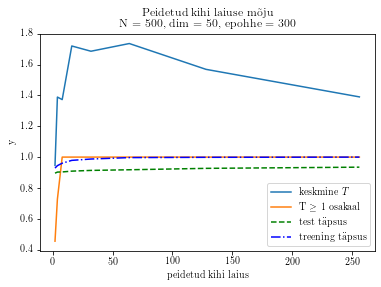

In [15]:
#plt.plot(xx, (np.array(syg2[0])*8 + np.array(syg[0]))/11 , label = "ECE enne kalib.", color = "purple")
#plt.plot(xx, (np.array(syg2[1])*8 + np.array(syg[1]))/11, label = "ECE pärast kalib.", color = "pink")
plt.plot(xx, (np.array(syg2[2])*8 + np.array(syg[2])*3)/11, label = "keskmine $T$")
plt.plot(xx, (np.array(syg2[3])*8 + np.array(syg[3])*3)/11, label = "T $\geq$ 1 osakaal")
plt.plot(xx, (np.array(syg2[4])*8 + np.array(syg[4])*3)/11, label = "test täpsus", color = "green", ls = "--")
plt.plot(xx, (np.array(syg2[5])*8 + np.array(syg[5])*3)/11, label = "treening täpsus", color = "blue", ls = "-.")
plt.legend()
plt.xlabel("peidetud kihi laius")
plt.ylabel("y")
plt.title("Peidetud kihi laiuse mõju \n N = $%s$, dim = $%s$, epohhe = $300$" % (nx, dim))
plt.savefig(path + "suurus2.png", bbox_inches='tight', dpi = 300)

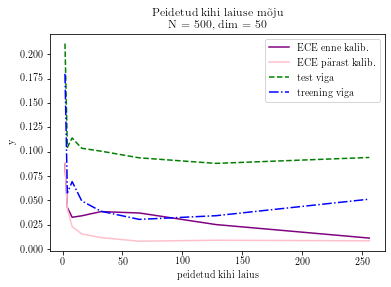

In [16]:
syg3 = np.array([
 np.array([0.0875,0.0426,0.0326,0.0341,0.0384, 0.037,0.0251,0.0112]),
 np.array([0.0888,0.0409,0.023,0.0155,0.0117,0.008,0.009,0.0084]),
 np.array([1.07407249,1.3278773,1.40032154,1.47787167,1.639,1.62102505,1.35416396,1.07422898]),
 np.array([0.3,1.,0.9,1.,1., 1.,1.,0.9]),
 np.array([0.78887904,0.895553,0.8859221,0.896508,0.8994621, 0.90633,0.912036,0.905962]),
 np.array([0.82,0.9424,0.9308,0.9506,0.9611999,0.9696,0.96580005,0.94879997]),
 np.array([111.6,209.9,187.3,182.9,143.5, 112.3,76.5,37.9])])

nx = 500
dim = 50

xx = [2,4,8,16,32,64,128,256]
plt.plot(xx, syg3[0] , label = "ECE enne kalib.", color = "purple")
plt.plot(xx, syg3[1], label = "ECE pärast kalib.", color = "pink")
#plt.plot(xx, (np.array(syg2[2])*8 + np.array(syg[2])*3)/11, label = "keskmine temp.")
#plt.plot(xx, 1- (np.array(syg2[3])*8 + np.array(syg[3])*3)/11, label = "T > 1 osakaal")
plt.plot(xx, 1 -syg3[4], label = "test viga", color = "green", ls = "--")
plt.plot(xx, 1 - syg3[5], label = "treening viga", color = "blue", ls = "-.")
#plt.plot(xx, 1 - syg3[5], label = "tr. viga", color = "blue", ls = "-.")

plt.legend()
plt.xlabel("peidetud kihi laius")
plt.ylabel("y")
plt.title("Peidetud kihi laiuse mõju \n N = $%s$, dim = $%s$" % (nx, dim))
plt.savefig(path + "suurus_norm1.png", bbox_inches='tight', dpi = 300)


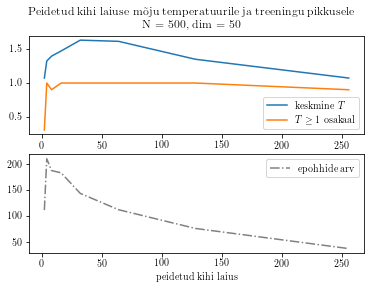

In [17]:
fig, axs = plt.subplots(2)
fig.suptitle('Peidetud kihi laiuse mõju temperatuurile ja treeningu pikkusele\n N = $%s$, dim = $%s$' % (nx, dim))

axs[0].plot(xx, syg3[2], label = "keskmine $T$")
axs[0].plot(xx, syg3[3], label = "$T \geq 1$ osakaal")
#axs[0].plot(xx, syg3[4], label = "te. täpsus", color = "green", ls = "--")
#axs[0].plot(xx, syg3[5], label = "tr. täpsus", color = "blue", ls = "-.")
axs[1].plot(xx, syg3[6], label = "epohhide arv", color = "grey", ls = "-.")

axs[0].legend()
axs[1].legend()

plt.xlabel("peidetud kihi laius")


plt.savefig(path + "suurus_norm2.png", bbox_inches='tight', dpi = 300)


In [37]:
def make_plot(data, cc, testing, not_test, n_feat, param,hs,name, clusts = 1):
  avg_loss_enne, avg_loss_prst, avg_res, ratios, avg_te_acc, avg_tr_acc, median_res,  dd_tr, dd_te, samp_y, weights, biases, xx = data
  max_test = (cc[np.argmax(avg_te_acc)],np.max(avg_te_acc))
  min_loss = (cc[np.argmax(-np.array(avg_loss_prst))],np.min(avg_loss_prst))
  min_loss_enne = (cc[np.argmax(-np.array(avg_loss_enne))],np.min(avg_loss_enne))
  indes = np.argmax(-np.abs(np.ones(len(cc)) - np.array(avg_res)))
  #print(cc, ratios, indes)
  #temp_one = (cc[indes], ratios[indes])
  plt.plot(cc, avg_tr_acc, color = "#439c93", label = "treening täpsus")
  plt.plot(cc, avg_te_acc, color = "#8ac953", linestyle = "--", label = "test täpsus")
  plt.plot(cc, avg_loss_prst, color = "#c253c9", linestyle = "-.", label = "NLL pärast kalib.")
  plt.plot(cc, avg_loss_enne, color = "#c98253", linestyle = "-.", label = "NLL enne kalib.")
  plt.plot(cc, ratios, color = "pink", label = "treening NLL") #label = "ratio of t > 1")
  plt.scatter(max_test[0], max_test[1], color = "#8ac953")
  plt.scatter(min_loss[0], min_loss[1], color = "#c253c9")
  plt.scatter(min_loss_enne[0], min_loss_enne[1], color = "#c98253")
  #plt.scatter(temp_one[0], temp_one[1], color = "pink")


  #plt.plot(cc, avg_eces_enne)
  #plt.plot(cc, avg_eces_prst)
  #plt.xscale("log")
  plt.ylim((-0.1,1.1))
  plt.xlabel("%s" % (testing))
  #plt.legend(("train_acc", "test_acc", "t > 1 ratio"))
  title = "NN: kadu ja täpsus sõltuvalt epohhist  \n (%s = %s, dim = %s, peidetud kihi suurus = %s)" % ( not_test, param, n_feat, hs)
  plt.title(title)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.savefig(path + "%s.png" % (name), bbox_inches='tight',dpi = 300)
  plt.clf()

In [38]:
def make_temp_plot(data,y_val, cc, testing, not_test,n_feat, param,hs,name, clusts = 1, make_other = False, temp_med=None, ratios= None):
  
  loss_enne, loss_prst, avg_res, ratios, te_acc, tr_acc, median_res, dd_tr, dd_te, samp_y, res_tr, dd_ca, xx = data

  vahe_te_1_buf = (dd_te[:].T[0] - dd_te[:].T[1])[y_val == 1].T
  vahe_te_0_buf = (dd_te[:].T[0] - dd_te[:].T[1])[y_val == 0].T
  sd1 = np.std(vahe_te_0_buf, axis = 1)
  sd2 = np.std(vahe_te_1_buf, axis = 1)
  vahe_te_1 = np.mean(vahe_te_1_buf, axis = 1)
  vahe_te_0 = np.mean(vahe_te_0_buf, axis = 1)

  temp_teor = ((sd1 + sd2)/2)**2/np.abs(vahe_te_1-vahe_te_0)

  #diff = avg_res - np.concatenate((avg_res[1:],np.array([1])))
  #avg_res[diff > 0.05] = np.concatenate((avg_res[1:], np.array([1])))[diff > 0.05]
  plt.plot(cc, avg_res, color = "#eb4979", label = "keskmine $T$")
  #plt.plot(cc, res_tr, color = "#496eeb", label = "tr. keskmine temp.")
  plt.plot(cc, np.ones(len(cc))*1, color = "pink")
  #plt.plot(cc, np.ones(len(cc))*2.8, color = "grey", ls = "--")
  
  if make_other == True:
     plt.plot(cc, temp_med, color = "purple", label = "mediaan $T$")
     plt.plot(cc, ratios, color = "black", label = "$T\geq1$ osakaal")
  #plt.xscale("log")
  #plt.plot(cc, temp_teor, color = "orange", alpha = 0.5, label = "teoreetiline $T$", lw = 4)
  plt.yscale("log")
  #plt.ylim((0,4))
  plt.xlabel("%s" % (testing))
  #plt.legend(("train_acc", "test_acc", "t > 1 ratio"))
  plt.title("NN: $T$ sõltuvalt epohhist \n (%s = %s, dim = %s, peidetud kihi suurus = %s)" % (not_test, param, n_feat, hs))
  plt.legend()
  plt.savefig(path + "%s.png" % (name),dpi = 300)
  plt.show()
  plt.clf()

In [8]:
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

In [39]:
def make_plot_distr(data,y_val, res_cc,cc, testing, not_test, n_feat, param,hs,name, clusts = 1, metric = "mean"):
  loss_enne, loss_prst, res, ratio, te_acc, tr_acc, loss, dd_tr, dd_te, samp_y, res_tr, dd_ca, xx = data
  
  dd_tr_ca = np.array(dd_tr)/np.array(res).reshape((1,1,-1)).T

  vahe_tr_1_buf = (dd_tr[:].T[0] - dd_tr[:].T[1])[samp_y== 1].T
  vahe_tr_0_buf = (dd_tr[:].T[0] - dd_tr[:].T[1])[samp_y== 0].T
  vahe_te_1_buf = (dd_te[:].T[0] - dd_te[:].T[1])[y_val == 1].T
  vahe_te_0_buf = (dd_te[:].T[0] - dd_te[:].T[1])[y_val == 0].T
  vahe_ca_1_buf = (dd_ca[:].T[0] - dd_ca[:].T[1])[y_val == 1].T
  vahe_ca_0_buf = (dd_ca[:].T[0] - dd_ca[:].T[1])[y_val == 0].T
 
  #vahe_tr_1_buf = dd_tr[:].T[0][samp_y== 1].T
  #vahe_tr_0_buf = dd_tr[:].T[0][samp_y== 0].T
  #vahe_te_1_buf = dd_te[:].T[0][y_val == 1].T
  #vahe_te_0_buf = dd_te[:].T[0][y_val == 0].T
  #vahe_ca_1_buf = dd_ca[:].T[0][y_val == 1].T
  #vahe_ca_0_buf = dd_ca[:].T[0][y_val == 0].T

  if metric == "median":
    vahe_tr_1 = np.median(vahe_tr_1_buf, axis = 1)
    vahe_tr_0 = np.median(vahe_tr_0_buf, axis = 1)
    vahe_te_1 = np.median(vahe_te_1_buf, axis = 1)
    vahe_te_0 = np.median(vahe_te_0_buf, axis = 1)
    vahe_ca_1 = np.median(vahe_ca_1_buf, axis = 1)
    vahe_ca_0 = np.median(vahe_ca_0_buf, axis = 1)
    #vahe_ca_1_tr = np.median((dd_tr_ca[:].T[0] - dd_tr_ca[:].T[1])[samp_y == 1].T, axis = 1)
    #vahe_ca_0_tr = np.median((dd_tr_ca[:].T[0] - dd_tr_ca[:].T[1])[samp_y == 0].T, axis = 1)

  else:
    vahe_tr_1 = np.mean(vahe_tr_1_buf, axis = 1)
    vahe_tr_0 = np.mean(vahe_tr_0_buf, axis = 1)
    vahe_te_1 = np.mean(vahe_te_1_buf, axis = 1)
    vahe_te_0 = np.mean(vahe_te_0_buf, axis = 1)
    vahe_ca_1 = np.mean(vahe_ca_1_buf, axis = 1)
    vahe_ca_0 = np.mean(vahe_ca_0_buf, axis = 1)

    #vahe_ca_1_tr = np.mean((dd_tr_ca[:].T[0] - dd_tr_ca[:].T[1])[samp_y == 1].T, axis = 1)
    #vahe_ca_0_tr = np.mean((dd_tr_ca[:].T[0] - dd_tr_ca[:].T[1])[samp_y == 0].T, axis = 1)


  #scores_tr_max = np.mean(np.min(np.array(distr_of_scores_tr), axis = 2), axis = 1)
  #scores_tr_min = np.mean(np.max(np.array(distr_of_scores_tr), axis = 2), axis = 1)
  #scores_te_max = np.mean(np.min(np.array(distr_of_scores_te), axis = 2), axis = 1)
  #scores_te_min = np.mean(np.max(np.array(distr_of_scores_te), axis = 2), axis = 1)
  diff_tr = np.abs(vahe_tr_1 - vahe_tr_0)
  diff_te = np.abs(vahe_te_1 - vahe_te_0)

  min_diff = (res_cc[np.argmax(-np.abs(diff_tr - diff_te))],np.min(np.abs(diff_tr - diff_te)))
  tt = diff_tr[-1] > diff_te[-1]
  plt.plot(res_cc, vahe_tr_1, color = "#8a5511", label = "treen. skooride $\mu_1$")
  plt.plot(res_cc, vahe_tr_0, color = "#8a5511", label = "treen. skooride $\mu_0$")
  plt.plot(res_cc, vahe_ca_1, color = "#cc8325", label = "val. kalib. skooride $\mu_1$", linestyle = "-.")
  plt.plot(res_cc, vahe_ca_0, color = "#cc8325", label = "val. kalib. skooride $\mu_0$", linestyle = "-.")
  #plt.plot(res_cc, vahe_ca_1_tr, color = "red", label = "scores_tr_cal_m1", linestyle = "--", alpha = 0.7)
  #plt.plot(res_cc, vahe_ca_0_tr, color = "red", label = "scores_tr_cal_m2", linestyle = "--", alpha = 0.7)
  
  plt.plot(res_cc, vahe_te_1, color = "#403629", linestyle = "--", label = "val. skooride $\mu_1$")
  plt.plot(res_cc, vahe_te_0, color = "#403629",  linestyle = "--",label = "val. skooride $\mu_0$") #label = "ratio of t > 1")
  plt.plot(res_cc, diff_tr, color = "#e0c7a6",  label = "treen. $\mu_1 - \mu_0$")
  plt.plot(res_cc, diff_te, color = "#e0c7a6", linestyle = "-.", label = "val. $\mu_1 - \mu_0$") #label = "ratio of t > 1")
  plt.plot(res_cc, res, color = "pink", label = "$T$" )
  #plt.scatter(min_diff[0], min_diff[1], color = "purple")
  plt.plot(res_cc, np.ones(len(res_cc)), color = "lightblue", alpha = 0.5)
  limitter_v = np.min([np.min(vahe_tr_1), np.min(vahe_te_1)])
  limitter_p = np.max(vahe_tr_0)
  limmer = np.max([np.max(diff_te),np.max(diff_tr)])
  
  plt.ylim((np.min([limitter_v,  np.min(vahe_tr_0)]) - 0.1,np.max([limitter_p,limmer]) + 0.1))
  plt.xlabel("%s" % (testing))
  #plt.legend(("train_acc", "test_acc", "t > 1 ratio"))
  title = "NN: jaotused sõltuvalt epohhist \n (%s = %s, dim = %s, peidetud kihi suurus = %s)" % (not_test, param, n_feat, hs)
  plt.title(title)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.savefig(path + "%s.png" % (name), bbox_inches='tight',dpi = 300)
  plt.clf()
  return vahe_tr_1, vahe_tr_0, vahe_te_1, vahe_te_0, diff_tr, diff_te

In [40]:
def calc_two(scores, amount = 100_000):
  mu = np.mean(scores)
  st = np.std(scores)
  divs = np.array([kl_div(np.random.normal(mu,st,amount), 50, False) for i in range(100)])
  q1 = np.quantile(divs, 0.95)
  q2 = np.quantile(divs, 0.05)
  
  return (q1, q2)

def p_val(scores, amount= 100_000):
  mu = np.mean(scores)
  st = np.std(scores)
  sample = np.random.normal(mu,st,amount)
  stats = []
  N = len(scores)
  sub = kl_div(scores, 50, False) - kl_div(sample, 50, False)
  union = np.concatenate((sample, scores))
  for i in range(100):
    perm = np.random.permutation(union)
    stats.append(kl_div(perm[:N], 50, False) - kl_div(perm[N:], 50, False))
  p_val = np.sum(np.array(stats) > sub)/100

  return p_val

def make_plot_div(data,y_val, res_cc,cc, testing, not_test, n_feat, param,hs,name, pv = False, clusts = 1):
  loss_enne, loss_prst, res, ratio, te_acc, tr_acc, loss, dd_tr, dd_te, samp_y, weights, biases, xx = data
  dd_te = np.array(dd_te)
  dd_tr = np.array(dd_tr)
  
  #vahe_tr_1_buf = dd_tr[:].T[0][samp_y== 1].T
  #vahe_tr_0_buf = dd_tr[:].T[0][samp_y== 0].T
  #vahe_te_1_buf = dd_te[:].T[0][y_val == 1].T
  #vahe_te_0_buf = dd_te[:].T[0][y_val == 0].T

  vahe_tr_1_buf = (dd_tr[:].T[0] - dd_tr[:].T[1])[samp_y== 1].T
  vahe_tr_0_buf = (dd_tr[:].T[0] - dd_tr[:].T[1])[samp_y== 0].T
  vahe_te_1_buf = (dd_te[:].T[0] - dd_te[:].T[1])[y_val == 1].T
  vahe_te_0_buf = (dd_te[:].T[0] - dd_te[:].T[1])[y_val == 0].T

  inters_cc = np.arange(0,len(vahe_te_1_buf), 20)
  
  kl_tr_1_inters = [calc_two(vahe_tr_1_buf[i], len(samp_y)) for i in inters_cc]
  kl_tr_0_inters = [calc_two(vahe_tr_0_buf[i], len(samp_y)) for i in inters_cc]
  kl_te_1_inters = [calc_two(vahe_te_1_buf[i]) for i in inters_cc]
  kl_te_0_inters = [calc_two(vahe_te_0_buf[i]) for i in inters_cc]

  kl_tr_1 = [kl_div(vahe, 100, pic = False) for vahe in vahe_tr_1_buf]
  kl_tr_0 = [kl_div(vahe, 100, pic = False) for vahe in vahe_tr_0_buf]
  kl_te_1 = [kl_div(vahe, 100, pic = False) for vahe in vahe_te_1_buf]
  kl_te_0 = [kl_div(vahe, 100, pic = False) for vahe in vahe_te_0_buf]

  vahe_tr_1 = np.mean(vahe_tr_1_buf, axis = 1)
  vahe_tr_0 = np.mean(vahe_tr_0_buf, axis = 1)
  vahe_te_1 = np.mean(vahe_te_1_buf, axis = 1)
  vahe_te_0 = np.mean(vahe_te_0_buf, axis = 1)

  diff_tr = np.abs(vahe_tr_1 - vahe_tr_0)
  diff_te = np.abs(vahe_te_1 - vahe_te_0)
  
  min_diff = (cc[np.argmax(-np.abs(diff_tr - diff_te))],np.min(np.abs(diff_tr - diff_te)))
  tt = diff_tr[-1] > diff_te[-1]
  plt.plot(inters_cc, kl_tr_1_inters, label = "treen. $1$ teor. erinevus" ,linestyle = "--" ,color = "lightblue")
  plt.plot(inters_cc, kl_tr_0_inters, label = "treen. $0$ teor. erinevus",linestyle = "--", color = "darkred" )
  plt.plot(inters_cc, kl_te_1_inters, label = "val. $1$ teor. erinevus" , color = "lightblue")
  plt.plot(inters_cc, kl_te_0_inters, label = "val. $0$ teor. erinevus", color = "darkred" )
  plt.plot(res_cc, kl_tr_1, color = "#8a5511", label = "treen. $1$ erinevus")
  plt.plot(res_cc, kl_tr_0, color = "#8a5511", label = "treen. $0$  erinevus", linestyle = "--")
  plt.plot(res_cc, kl_te_1, color = "#403629", label = "val. $1$  erinevus")
  plt.plot(res_cc, kl_te_0, color = "#403629",  linestyle = "--",label = "val. $0$  erinevus") #label = "ratio of t > 1")
  #plt.plot(cc, diff_tr, color = "#e0c7a6",  label = "tr_diff")
  #plt.plot(cc, diff_te, color = "#e0c7a6", linestyle = "-.", label = "te_diff") #label = "ratio of t > 1")
  plt.plot(res_cc, res, color = "pink", label = "$T$" )
  #plt.scatter(min_diff[0], min_diff[1], color = "purple")
  plt.plot(res_cc, np.ones(len(res_cc)), color = "lightblue", alpha = 0.5)
  limitter_v = np.min([np.min(vahe_tr_1), np.min(vahe_te_1)])
  limitter_p = np.max(vahe_tr_0)
  limmer = np.max([np.max(diff_te),np.max(diff_tr)])
  plt.yscale("log")
  #plt.ylim((limitter_v - 0.1,np.max([limitter_p,limmer]) + 0.1))
  plt.xlabel("%s" % (testing))
  #plt.legend(("train_acc", "test_acc", "t > 1 ratio"))
  title = "NN: jaotuste erinevused normaaljaotusest sõltuvalt epohhist  \n (%s = %s, dim = %s, peidetud kihi suurus = %s)" % (not_test, param, n_feat, hs)
  plt.title(title)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.savefig(path + "%s.png" % (name), bbox_inches='tight',dpi = 300)
  plt.clf()
  if pv == True:      
    kl_te_0_pval = [np.mean(np.array([p_val(vahe_te_0_buf[i]) for j in range(10)])) for i in inters_cc]
    kl_te_1_pval = [np.mean(np.array([p_val(vahe_te_1_buf[i]) for j in range(10)])) for i in inters_cc]
    kl_tr_0_pval = [np.mean(np.array([p_val(vahe_tr_0_buf[i], len(samp_y)) for j in range(10)])) for i in inters_cc]
    kl_tr_1_pval = [np.mean(np.array([p_val(vahe_tr_1_buf[i], len(samp_y)) for j in range(10)])) for i in inters_cc]
  
    plt.plot(inters_cc,kl_te_0_pval, color = "pink", label = "te_1")
    plt.plot(inters_cc,kl_te_1_pval, color = "purple", label = "te_2")
    plt.plot(inters_cc,kl_tr_0_pval, color = "pink",linestyle = "--", label = "tr_1")
    plt.plot(inters_cc,kl_tr_1_pval, color = "purple", linestyle = "--", label = "tr_2")
    plt.plot(inters_cc, np.ones(len(inters_cc))*0.05)
    plt.title("p-values")
    plt.legend()
    plt.savefig(path + "p_vals_%s" %(test))
    plt.clf()

  return kl_tr_1, kl_tr_0, kl_te_1, kl_te_0, kl_te_1_inters

In [10]:
def get_jaotus(data,i, y, title, abbr, tr = False, c = 0, d= 0 , bins = 50):

  andmed_te = data[i]

  vahe = andmed_te.T[0] - andmed_te.T[1]
  plt.hist(vahe[y == 0], bins,alpha = 0.5, density = True,color = "red", label = "$0$ klassi skoorijaotus")
  plt.hist(vahe[y == 1], bins,alpha = 0.5,density = True, color = "blue", label = "$1$ klassi skoorijaotus")
  kl_1 = kl_div(vahe[y == 0], bins, col = "red", lab = "$0$ klassi norm. lähend")
  kl_2 = kl_div(vahe[y == 1], bins, col = "blue", lab = "$1$ klassi norm. lähend")

  sd1, sd2 = np.std(vahe[y == 0]), np.std(vahe[y == 1])
  #plt.hist(andmed_te, 30,density = True,alpha = 0.5, color = "red")
  #plt.hist(andmed_te.T[1], 30, density = True,alpha = 0.5,color = "blue")
  a, b = np.mean(vahe[y == 0]), np.mean(vahe[y == 1])
  temp_teor = ((sd1 + sd2)/2)**2/np.abs(b-a)
  #a, b = np.mean(andmed_te.T[0]), np.mean(andmed_te.T[1])
  if tr == True:
    plt.scatter(c,0.01,color = "darkred", label = "val. $\mu_0$")
    plt.scatter(d,0.01,color = "blue", label = "val. $\mu_1$")
    plt.scatter(a,0.02,color = "red", marker = "v", label= "treen. $\mu_0$")
    plt.scatter(b,0.02,color = "blue", marker = "v", label = "treen. $\mu_1$")
  else:
    plt.scatter(b,0.01,color = "blue", label = "val. $\mu_1$")
    plt.scatter(a,0.01,color = "red", label = "val. $\mu_0$")
  diff = np.abs(b-a)
  plt.legend()
  plt.xlabel("skoor")
  plt.title("NN %sskooride jaotus  \n (epohh: %s, $T$: %s, $\mu_0$ = %s, $\mu_1$ = %s,\n peidetud kihi suurus = %s, $N$ = %s, dim = %s, \n KL0 = %s; KL1=%s, $T_{teor}$ = %s)" % (title,i , np.round(result[2][i], 2), np.round(a,5),np.round(b,5),hs, nx, dim, np.round(kl_1,5), np.round(kl_2,5), np.round(temp_teor,3)))
  plt.savefig(path + "NN_skoorid_%s%s.png" % (abbr,test),bbox_inches = "tight" ,dpi = 300)
  plt.show()
  plt.clf()
  return a,b


In [41]:
def train_model(model, batch): #binary crossentropy??
    cross_entropy = losses.SparseCategoricalCrossentropy(from_logits=True)
    #cross_entropy = losses.BinaryCrossentropy(from_logits= True)
    sgd = optimizers.SGD()
    with tf.GradientTape() as tape:
        outp = model(batch[0]) 
        #loss = cross_entropy(batch[1].reshape((-1,1)), outp) #shape bin!
        loss = cross_entropy(batch[1], outp) 
          
    grads = tape.gradient(loss, model.trainable_variables)
  
    sgd.apply_gradients(zip(grads, model.trainable_variables)) 

    return loss.numpy()

def eval_model(model, data): 
    accuracy = metrics.SparseCategoricalAccuracy()
    #accuracy = metrics.BinaryAccuracy()
    accs = []
    #accuracy.update_state(data[1].reshape((-1,1)), model(data[0])) #shape bin!  
    accuracy.update_state(data[1] , model(data[0]))  
     
    acc = accuracy.result()
    return acc.numpy()

        

In [42]:
def nn_pipe_det(data, size_dense,n_feat, nr_of_epochs = 40, nx = 1000):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    ny = 1000
    #nx = 1000
    highest = []
    res = []
    res_tr = []
    eces_enne = []
    tr_acc = []
    te_acc = []
    eces_prst = []
    loss_enne = []
    loss_prst = []
    loss=[]
    distr_of_scores_tr = []
    distr_of_scores_te = []
    distr_of_scores_ca = []
    weights = []
    biases = []
    cc = []
    ind_1 = np.random.randint(0, len(X_train)//2, nx//2)
    ind_2 = np.random.randint(len(X_train)//2, len(X_train), nx//2)
    ind = np.concatenate((ind_1,ind_2))
    #ind = np.random.randint(0, len(X_train), nx)
    samp_x = X_train[ind]
    samp_y = y_train[ind]
    model = create_model(n_feat, [size_dense, 2])
    print(model.summary())
    
    for i in tqdm.tqdm(range(nr_of_epochs)):
        lossike = train_model(model, [samp_x, samp_y])
        logits = model(X_val).numpy()
        logits_test = model(X_test).numpy()
        logits_train = model(samp_x).numpy()
        logits_tr = model(X_train).numpy()
        
        distr_of_scores_te.append(logits) 
        distr_of_scores_tr.append(logits_train) 
        
        limitt = 20
        logits = np.where(abs(logits) > limitt, np.sign(logits)*limitt, logits)
        logits_test = np.where(abs(logits_test) > limitt, np.sign(logits_test)*limitt, logits_test)
        logits_train = np.where(abs(logits_train) > limitt, np.sign(logits_train)*limitt, logits_train)
#bin jaoks--

        #logits_b = np.log(1 - sigmoid(logits))
        #logits_train_b = np.log(1 - sigmoid(logits_train))
        #logits_test_b = np.log(1 - sigmoid(logits_test))
        
        #logits_train_a = np.log(sigmoid(logits_train))
        #logits_test_a = np.log(sigmoid(logits_test))
        #logits_a = np.log(sigmoid(logits))

        #logits_train_c = np.concatenate((logits_train_b, logits_train_a),axis = 1)
        #logits_test_c = np.concatenate((logits_test_b,logits_test_a),axis = 1)
        #logits_c = np.concatenate((logits_b,logits_a),axis = 1)

        #print(logits_c[0])
#-----------
        weights.append(model.trainable_variables[-2].numpy())
        biases.append(model.trainable_variables[-1].numpy())
      
        #probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()]) 
        #confidences = probability_model.predict(X_val)
        #confidences_te = probability_model.predict(X_test)
        #logits_v = to_logits(confidences)
        #logits_test = to_logits(confidences_te)
        #print(logits_v[0], logits[0])
        try:
          temperature = cal_methods_slim.TemperatureScaling()
          temperature.fit(logits, y_val)
          res.append(temperature.temp)
    
        except:
          print("te_viga")
          res.append(res[-1])

        try:
          
          temp_train = cal_methods_slim.TemperatureScaling()
          temp_train.fit(logits_train, samp_y)
        except:
          print("tr_viga")
          
        
        
        #conf2 = temperature.predict(logits)
        loss.append(lossike)
      
        res_tr.append(temp_train.temp)
        distr_of_scores_ca.append(distr_of_scores_te[-1]/res[-1])
        #distr_of_scores_ca.append(logits_tr)
        loss_enne.append(temperature._loss_fun(1, logits_test, y_test))
        loss_prst.append(temperature._loss_fun(res[-1], logits_test, y_test))
        te_acc.append(eval_model(model,[X_val, y_val]))
        tr_acc.append(eval_model(model,[samp_x, samp_y]))
        cc.append(i)
        print(temperature.temp)
        #if len(res) >= 2:
        #  if res[-1] >= 1 and res[-1] > res[-2]:
        #    break
        #  if res[-1] < 1 and res[-1] < res[-2]:
        #    break
    res = np.array(res)
    ratio = np.array(loss)
    #print(model.trainable_variables[-2].numpy())
    return np.array(loss_enne), np.array(loss_prst), res, np.array(ratio), np.array(te_acc), np.array(tr_acc), np.array(loss), np.array(distr_of_scores_tr), np.array(distr_of_scores_te), samp_y, np.array(res_tr), np.array(distr_of_scores_ca), np.array(cc), samp_x

In [43]:
from scipy.stats import norm 
def kl_div(scores, bins, pic = True, col = "black", lab = ""):
  mu = np.mean(scores)
  std = np.std(scores)
  
  
  hist = np.histogram(scores, bins, normed =True)
  estim = hist[0] 
  buckets = hist[1]
  wid = (buckets[1] - buckets[0])/2
  buckets = buckets[1:] - wid
  etalon = norm.pdf(buckets, mu, std)
  if pic == True:
    plt.plot(buckets, etalon, color = col, label  = lab)
  #print(etalon, estim)
  return np.sum(estim * np.log(estim  / etalon, where = estim != 0))


In [11]:
def softmax(X, t):
    return np.exp(X/t) / np.sum(np.exp(X/t), axis=0)  

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
np.random.seed(38) #38, 200, 10 /20 ja 50 / 15 ja 73 /50,10 ja 73 /10 ja 100 ,74
mu_1, mu_2 = np.array([5,1]), np.array([-5,1])
sgm = np.identity(2) * np.array([50,50])
nx = 150
ny = 5000

cmap_light = ["pink", "purple"]

distr_1 = np.random.multivariate_normal(mu_1 , sgm, nx) #negatives
val_1 =  np.random.multivariate_normal(mu_1 , sgm, ny)

val_2 =  np.random.multivariate_normal(mu_2, sgm, ny) #positives
distr_2 = np.random.multivariate_normal(mu_2 , sgm, nx)

val_y = np.concatenate((np.zeros(ny), np.ones(ny)))
samp_y = np.concatenate((np.zeros(nx),np.ones(nx)))
samp_x = np.concatenate((distr_1,distr_2))
val_x = np.concatenate((val_1, val_2))
neigh = KNeighborsClassifier(n_neighbors=10, p = 2)
neigh.fit(samp_x, samp_y)

buf_x = np.concatenate((val_x,samp_x))
buf_y = np.concatenate((val_y,samp_y))

#probs_opt = sigmoid_mod(samp_x.T[0]).reshape(-1,1)
probs_opt = sigmoid_mod(val_x.T[0]).reshape(-1,1)

probs_val = neigh.predict_proba(val_x)
probs_tr = neigh.predict_proba(samp_x)
probs_opt = np.concatenate((1-probs_opt,probs_opt),axis = 1)

temperature_val = cal_methods_slim.TemperatureScaling()
temperature_tr = cal_methods_slim.TemperatureScaling()
temperature_opt = cal_methods_slim.TemperatureScaling()

temperature_val.fit(to_logits(probs_val), val_y)
temperature_tr.fit(to_logits(probs_tr), samp_y)
temperature_opt.fit(to_logits(probs_opt), val_y)

print("val", temperature_val.temp)
print("tr", temperature_tr.temp)
print("opt", temperature_opt.temp)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


val 1.314049522268631
tr 0.9023318576542564
opt 0.9893316425240539


[1. 1. 1. ... 0. 0. 0.]


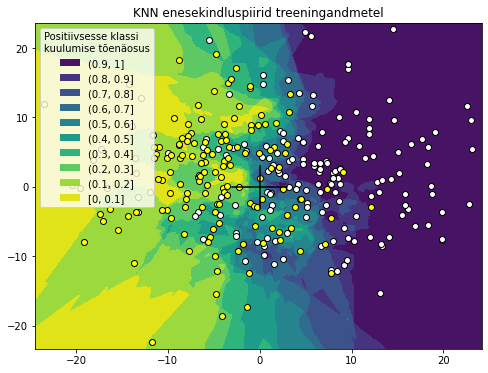

In [14]:

h = 0.1
x_min, x_max = samp_x[:, 0].min() - 1, samp_x[:, 0].max() + 1
y_min, y_max = samp_x[:, 1].min() - 1, samp_x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = neigh.predict_proba(np.c_[xx.ravel(), yy.ravel()]).T[1]
print(Z)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
cs = plt.contourf(xx, yy, Z, levels = np.linspace(0,1,11))
#plt.scatter(val_x[val_y == 0].T[0], val_x[val_y == 0].T[1], color = "pink", edgecolor="black")
#plt.scatter(val_x[val_y == 1].T[0], val_x[val_y == 1].T[1], color = "purple", edgecolor="black")
plt.scatter(samp_x[samp_y == 0].T[0], samp_x[samp_y == 0].T[1], color = "white", edgecolor="black")
plt.scatter(samp_x[samp_y == 1].T[0], samp_x[samp_y == 1].T[1], color = "yellow", edgecolor="black")

plt.plot([-3,3], [0,0], c = "black")
plt.plot([0,0], [-3,3], c = "black")

proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) 
    for pc in cs.collections]
labs = ["[0, 0.1]", "(0.1, 0.2]", "(0.2, 0.3]", "(0.3, 0.4]","(0.4, 0.5]","(0.5, 0.6]","(0.6, 0.7]",
                   "(0.7, 0.8]","(0.8, 0.9]","(0.9, 1]"]
labs = [labs[-(i+1)] for i in range(len(labs)) ]
plt.legend(proxy,labs,title = "Positiivsesse klassi \nkuulumise tõenäosus")
plt.title("KNN enesekindluspiirid treeningandmetel")
plt.savefig(path + "piirid_tr_1.png", dpi = 300)

[0.00747414 0.00762398 0.0077768  ... 0.99176584 0.99192758 0.99208616]


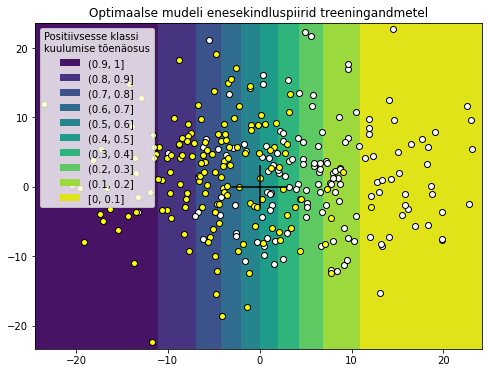

In [15]:
def sigmoid_mod(X):
    #mu0, mu1 = np.mean(X, axis = 0)
    #st = np.mean(np.std(X,axis=0))
    w = -10/50 #(mu1 - mu0)/st**2
    b = 0 #(mu0**2 - mu1**2)/(2*st**2)
    return 1/(1+ np.exp(-(X*w + b)))


h = 0.1
x_min, x_max = samp_x[:, 0].min() - 1, samp_x[:, 0].max() + 1
y_min, y_max = samp_x[:, 1].min() - 1, samp_x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = 1 - sigmoid_mod(np.c_[xx.ravel(), yy.ravel()]).T[0]
print(Z)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels = np.linspace(0,1,11))
#plt.scatter(val_x[val_y == 0].T[0], val_x[val_y == 0].T[1], color = "pink", edgecolor="black")
#plt.scatter(val_x[val_y == 1].T[0], val_x[val_y == 1].T[1], color = "purple", edgecolor="black")
plt.scatter(samp_x[samp_y == 0].T[0], samp_x[samp_y == 0].T[1], color = "white", edgecolor="black")
plt.scatter(samp_x[samp_y == 1].T[0], samp_x[samp_y == 1].T[1], color = "yellow", edgecolor="black")

plt.plot([-3,3], [0,0], c = "black")
plt.plot([0,0], [-3,3], c = "black")
proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) 
    for pc in cs.collections]

plt.legend(proxy,labs , title = "Positiivsesse klassi \nkuulumise tõenäosus")
plt.title("Optimaalse mudeli enesekindluspiirid treeningandmetel")

plt.savefig(path + "piirid_opt.png", dpi = 300)

#print(neigh.predict_proba(val_x))

In [29]:
print(sum(np.argmax(probs_tr, axis = 1)  == samp_y)/len(samp_x))
print(sum(np.argmax(probs_val, axis = 1)  == val_y)/len(val_y))
print(sum(np.argmax(probs_opt, axis = 1)  == val_y)/len(val_y))


0.7966666666666666
0.7465
0.7601


In [17]:
#probs_opt = sigmoid_mod(samp_x.T[0]).reshape(-1,1)
probs_val = neigh.predict_proba(val_x)
probs_tr = neigh.predict_proba(samp_x)
#probs_opt = np.concatenate((probs_opt,1- probs_opt),axis = 1)

temperature_val = cal_methods_slim.TemperatureScaling()
temperature_tr = cal_methods_slim.TemperatureScaling()
#temperature_opt = cal_methods_slim.TemperatureScaling()

temperature_val.fit(to_logits(probs_val), val_y)
temperature_tr.fit(to_logits(probs_tr), samp_y)
temperature_opt.fit(to_logits(probs_opt), val_y)

print("val", temperature_val.temp)
print("tr", temperature_tr.temp)
print("opt", temperature_opt.temp)


val 1.314049522268631
tr 0.9023318576542564
opt 0.9893316425240539


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [18]:
logits_val = to_logits(probs_val)
min_val = np.min(logits_val[logits_val != -np.inf])
logits_val = np.where(abs(logits_val) == np.inf, min_val, logits_val)
logits_tr = to_logits(probs_tr)
min_tr = np.min(logits_tr[logits_tr != -np.inf])
logits_tr = np.where(abs(logits_tr) == np.inf, min_tr , logits_tr)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [40]:
def get_jaotus_knn(data,i, y, title, abbr, nx, bins = 50, hity = []):

  andmed_te = data[i]

  #vahe = andmed_te.T[0] - andmed_te.T[1]
  vahe = andmed_te.T[1]
  _, bins = np.histogram(vahe, bins)
  plt.hist(vahe[y == 0], bins,alpha = 0.5, density = True,color = "blue", label = "klass 0")
  plt.hist(vahe[y == 1], bins,alpha = 0.5,density = True, color = "red", label = "klass 1")
  if len(hity) != 0:
    andmed_te = hity[0]
    y = hity[1]
    vahe = andmed_te.T[1]
    plt.hist(vahe[y == 0], bins,alpha = 0.5, density = True,color = "blue", label = "klass 0 optimaalne", histtype = "step")
    plt.hist(vahe[y == 1], bins,alpha = 0.5,density = True, color = "red", label = "klass 1 optimaalne", histtype = "step")
  plt.legend()
  plt.xlabel("$P(X) = 1$")
  plt.title("KNN tõenäosuste jaotuse %s \n ($T$ = %s, $N$ = %s, dim = 2)" % (title, np.round(tempp,2), nx))
  plt.savefig(path + "KNN_skoorid_%s.png" % (abbr),bbox_inches = "tight" , dpi = 300)
  plt.show()



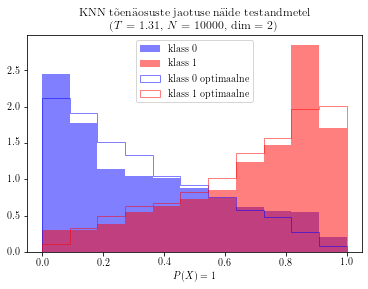

In [41]:
tempp = temperature_val.temp
get_jaotus_knn([probs_val], 0, val_y, "näide testandmetel", "val",10000, bins = 11, hity = (probs_opt,val_y))

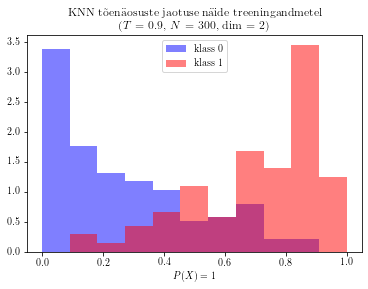

In [43]:
tempp = temperature_tr.temp
get_jaotus_knn([probs_tr], 0, samp_y, "näide treeningandmetel", "tr",nx*2, bins = 11)

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889] [0.1        0.2        0.3        0.4        0.5        0.6
 0.7        0.8        0.93584749]


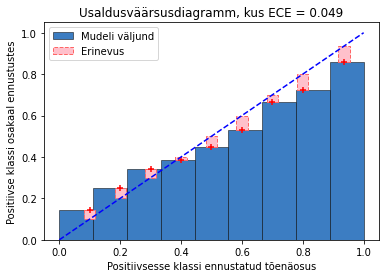

0.049

<Figure size 432x288 with 0 Axes>

In [32]:
test = 1
rel_diag(9 ,probs_val.T, val_y, title_save= "rel_nt_val_%s" % (test))

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889] [0.1        0.2        0.3        0.4        0.5        0.6
 0.7        0.8        0.92537313]


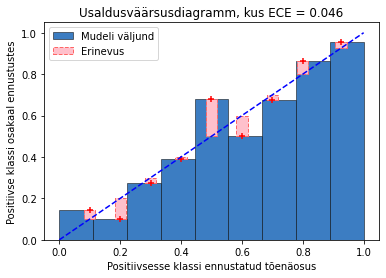

0.046

<Figure size 432x288 with 0 Axes>

In [33]:
rel_diag(9 ,probs_tr.T, samp_y, title_save= "rel_nt_tr_%s" % (test))

In [66]:
import pickle
def save_nostra_file(nr, tipo, kraam):
    with open(path + '%s_katse_%s.pickle' % (tipo, nr), 'wb') as f:
        pickle.dump(kraam, f)

def read_nostra_file(nr, tipo):
    with open(path + "%s_katse_%s.pickle" % (tipo, nr), "rb") as f:
        return pickle.load(f)


In [ ]:
nr = 47
n = 20
nx = 7000
dim = 10
epochs = 300

testik = "%s_b_over_%s" % (nr, n)
hsx = [64]
hs = 1
title = "N:%s, dim:%s, hs:%s" %(nx, dim, hs)
set_last = []

data = gen_data(dim, eri = False)
#data = gen_mc_data(dim, dim)

eces_enne = [] 
eces_prst = [] 
suurus = []
temps = []
for k, hs in enumerate(hsx):
  test = "%s_%sb_over_%s" % (nr, k, n)
  med_temp = []
  ratios = np.zeros(epochs)
  ece_p = 0
  ece_e = 0
  int1 = 0
  int2 = 0
  for i in range(n):
    
    
    print(data[0].shape)
    #data = gen_mc_data(dim, 1)
    #set_1 = [[],[],[],[],[],[],[]]

    result = np.array(nn_pipe_det(data, hs ,dim, epochs, nx))
    
    ratios += (result[2] > 1)/n
    med_temp.append(result[2])

    samp_x = result[-1]
    loss_enne, loss_prst, res, ratio, te_acc, tr_acc, loss, distr_of_scores_tr, distr_of_scores_te, samp_y, res_tr, distr_of_scores_ca, cc, samp_x = result
    result = result[:-1]
    #probs = softmax(result[-2][-1].T,1)
    #ece_p += rel_diag(25 ,probs, data[-1],supress = True,title_save= "rel_te_%s" % (test))

    #probs = softmax(result[-5][-1].T,1)
    #ece_e += rel_diag(25 ,probs, data[-1],supress = True,title_save= "rel_te_%s" % (test))

    #make_plot(result, result[-1], "epohh", "N", dim, nx, hs, "NN_%s_epochs_dim_%s" %(test+str(i),dim)  )
    #make_temp_plot(result, data[-1], result[-1], "epohh", "N", dim, nx,hs, "NN_%s_temp_epochs_dim_%s" %(test+str(i),dim), make_other = False,temp_med = med_temp,ratios= ratios  )
    #dist_data = make_plot_distr(result, data[-1], result[-1], np.arange(epochs),"epohh", "N", dim, nx,hs, "NN_%s_distr_mean_dim_%s_%s" %(test+str(i),dim,i)  )
    #div_data = make_plot_div(result,data[-1], result[-1],np.arange(epochs), "epohh", "N", dim, nx,hs, "NN_%s_div_epochs_dim_%s" %(test+str(i),dim) , pv = False )

    #get_jaotus(result[-2],-1,data[-1],"kalib. test","ca%s" %(i+1))
    #a,b = get_jaotus(result[-5],-1,data[-1],"test","te%s" %(i+1) )
    #get_jaotus(result[-6],-1,result[-4],"treening","tr%s" %(i+1) , True, a, b, 50)
    #get_mirrors(result[-6], result[-5], -1, result[-4], data[-1], "\n treening- ja valideerimisskoorid mediaanist peegeldatud", "tr_te%s" %(i+1), )
    #get_koos_jaotused(result[-6], result[-5], -1, result[-4], data[-1], "treening- ja valideerimisskoorid koos", "tr_te%s" %(i+1), )
    #ua ,ub = intersec(result[-6], result[-5], -1, result[-4], data[-1], "", "tr_te%s" %(i+1))
    #int1 += ua 
    #int2 += ub 
    #print(ua,ub)
    #probs = softmax(result[-5][-1].T,1)
    #rel_diag(25 ,probs, data[-1],title_save= "rel_te_%s" % (test+str(i)))
    #probs = softmax(result[-2][-1].T,1)
    #rel_diag(25 ,probs, data[-1], title_save= "rel_te_ca_%s" % (test+str(i)))
    #probs =  softmax(result[-6][-1].T, 1)
    #rel_diag(25 ,probs, result[-4], title_save= "rel_tr_%s" % (test+str(i)))
    #print("hidden layer: 64, dim: %s, nx: 500, epochs: %s" % (dim, epochs))
    if i == 0:
      set_1 = np.array([loss_enne, loss_prst, res, ratio, te_acc, tr_acc, loss, distr_of_scores_tr, distr_of_scores_te, samp_y, res_tr, distr_of_scores_ca, cc])/n
      set_1[7] = set_1[7]*n
      set_1[9] = (set_1[9]*n).astype(int)
    else:
      for j, linksi in enumerate(result):
        if j == 7:
          set_1[j] = np.concatenate((set_1[j], linksi), axis = 1)
        elif j == 9:
          set_1[j] = np.concatenate((set_1[j], linksi))
        else:
          set_1[j] += linksi/n
  print(ratios)
  #med_temp = np.median(np.array(med_temp), axis = 0)
  
  make_plot(set_1, result[-1], "epohh", "N", dim, nx, hs, "NN_%s_epochs_dim_%s" %(test,dim)  )
  make_temp_plot(set_1,data[-1], result[-1], "epohh", "N", dim, nx,hs, "NN_%s_temp_epochs_dim_%s" %(test,dim), make_other = False,temp_med = med_temp,ratios= ratios  )
  dist_data = make_plot_distr(set_1, data[-1], result[-1], np.arange(epochs),"epohh", "N", dim, nx,hs, "NN_%s_distr_mean_dim_%s_%s" %(test,dim,i)  )
  dist_data = make_plot_distr(set_1, data[-1], result[-1], np.arange(epochs),"epohh", "N", dim, nx,hs, "NN_%s_distr_median_dim_%s_%s" %(test,dim,i), metric = "median"  )
  div_data = make_plot_div(set_1,data[-1], result[-1],np.arange(epochs), "epohh", "N", dim, nx,hs, "NN_%s_div_epochs_dim_%s" %(test,dim) , pv = False )
  
  #get_jaotus(set_1[-2],-1,data[-1],"kalib. test","ca")
  #a,b = get_jaotus(set_1[-5],-1,data[-1],"test","te" )
  #get_jaotus(set_1[-6],-1,set_1[-4],"treening","tr" , True, a, b, 50)
  #print("yhisosad:%s, %s" %(int1/n, int2/n))

  make_plot(result, result[-1], "epohh", "N", dim, nx, hs, "NN_%s_epochs_dim_%s" %(test+str(i),dim)  )
  make_temp_plot(result, data[-1], result[-1], "epohh", "N", dim, nx,hs, "NN_%s_temp_epochs_dim_%s" %(test+str(i),dim), make_other = False,temp_med = med_temp,ratios= ratios  )
  dist_data = make_plot_distr(result, data[-1], result[-1], np.arange(epochs),"epohh", "N", dim, nx,hs, "NN_%s_distr_mean_dim_%s_%s" %(test+str(i),dim,i)  )
  div_data = make_plot_div(result,data[-1], result[-1],np.arange(epochs), "epohh", "N", dim, nx,hs, "NN_%s_div_epochs_dim_%s" %(test+str(i),dim) , pv = False )
  get_jaotus(result[-2],-1,data[-1],"kalib. valideerimis","ca%s" %(i+1))
  a,b = get_jaotus(result[-5],-1,data[-1],"valideerimis","te%s" %(i+1) )
  get_jaotus(result[-6],-1,result[-4],"treening","tr%s" %(i+1) , True, a, b, 50)
  get_mirrors(result[-6], result[-5], -1, result[-4], data[-1], "\n treening- ja valideerimisskoorid mediaanist peegeldatud", "tr_te%s" %(i+1), )
  get_koos_jaotused(result[-6], result[-5], -1, result[-4], data[-1], "treening- ja valideerimisskoorid koos", "tr_te%s" %(i+1), )
  intersec(result[-6], result[-5], -1, result[-4], data[-1], "", "tr_te%s" %(i+1))
  probs = softmax(result[-5][-1].T,1)
  rel_diag(25 ,probs, data[-1],title_save= "rel_te_%s" % (test+str(i)))
  probs = softmax(result[-2][-1].T,1)
  rel_diag(25 ,probs, data[-1], title_save= "rel_te_ca_%s" % (test+str(i)))
  probs =  softmax(result[-6][-1].T, 1)
  rel_diag(25 ,probs, result[-4], title_save= "rel_tr_%s" % (test+str(i)))

  save_nostra_file(0, "NN_n7000_d10", [result, data[-1]])
  blaa
  if k == 0:

    suurus.append(np.array([ece_e])/n)
    suurus.append(np.array([ece_p])/n)
    suurus.append(np.array(set_1[2][-1:]))
    suurus.append(np.array(ratios[-1:]))
    suurus.append(np.array(set_1[4][-1:]))
    suurus.append(np.array(set_1[5][-1:]))
    

    for m in range(len(set_1)-1):
      set_last.append(set_1[m][-1:])
    set_last.append([hs])
    set_last.append(med_temp[-1:])
    set_last.append(ratios[-1:])
  else:
    suurus[0] = np.concatenate((suurus[0],np.array([ece_e])/n))
    suurus[1] = np.concatenate((suurus[1],np.array([ece_p])/n))
    suurus[2] = np.concatenate((suurus[2],np.array(set_1[2][-1:])))
    suurus[3] = np.concatenate((suurus[3],np.array(ratios[-1:])))
    suurus[4] = np.concatenate((suurus[4],np.array(set_1[4][-1:])))
    suurus[5] = np.concatenate((suurus[5],np.array(set_1[5][-1:])))
    
    for m in range(len(set_1)-1):
      try:
        set_last[m] = np.concatenate((set_last[m],set_1[m][-1:]))
      except:
        print("skipped", m)
    set_last[-3].append(hs)
    set_last[-2] = np.concatenate((set_last[-2],med_temp[-1:]))
    set_last[-1] = np.concatenate((set_last[-1],ratios[-1:]))
  print(suurus)
set_last[9] = set_1[9]
med_temp = set_last[-1]
ratios = set_last[-2]
test = testik

set_last = set_last[:-2]

#make_plot(set_last, hsx, "epochs", "N", dim, nx, hs, "NN_%s_epochs_dim_%s" %(test,dim)  )
#make_temp_plot(set_last, hsx, "epochs", "N", dim, nx,hs, "NN_%s_temp_epochs_dim_%s" %(test,dim), make_other = True,temp_med = med_temp,ratios= ratios  )
#make_temp_plot(set_last,data[-1], result[-1], "epochs", "N", dim, nx,hs, "NN_%s_temp_epochs_dim_%s" %(test,dim), make_other = True,temp_med = med_temp,ratios= ratios  )
#dist_data = make_plot_distr(set_last, data[-1], hsx, np.arange(epochs),"epochs", "N", dim, nx,hs, "NN_%s_distr_mean_dim_%s_%s" %(test,dim,i)  )
#dist_data = make_plot_distr(set_last, data[-1], hsx, np.arange(epochs),"epochs", "N", dim, nx,hs, "NN_%s_distr_median_dim_%s_%s" %(test,dim,i), metric = "median"  )
#div_data = make_plot_div(set_last,data[-1], hsx,np.arange(epochs), "epochs", "N", dim, nx,hs, "NN_%s_div_epochs_dim_%s" %(test,dim) , pv = False )
  



In [ ]:
#intersec(result[-6], result[-5], -1, result[-4], data[-1],"", "tr_te", bins = 50)
get_mirrors(set_1[-6], set_1[-5], -1, set_1[-4], data[-1], "\n treening- ja valideerimisskoorid mediaanist peegeldatud", "tr_te", )
#get_koos_jaotused(set_1[-6], set_1[-5], -1, set_1[-4], data[-1], "treening- ja valideerimisskoorid koos", "tr_te", )

In [82]:
def get_koos_jaotused(data_tr, data_te,i, y_tr ,y_te, title, abbr, tr = False, bins = 50):

  andmed_te = data_tr[i]

  vahe = andmed_te.T[0] - andmed_te.T[1]
  plt.hist(vahe[y_tr == 0], bins,alpha = 0.5, density = True,color = "red", label = "treen. 0-klass")
  plt.hist(vahe[y_tr == 1], bins,alpha = 0.5,density = True, color = "blue", label = "treen. 1-klass")

  a, b = np.mean(vahe[y_tr == 0]), np.mean(vahe[y_tr == 1])
  andmed_te = data_te[i]
  vahe = andmed_te.T[0] - andmed_te.T[1]
  plt.hist(vahe[y_te == 0], 50,alpha = 0.75, density = True,color = "red", histtype = "step", linewidth=2.5,label = "val. 0-klass")
  plt.hist(vahe[y_te == 1], 50,alpha = 0.75,density = True, color = "blue", histtype = "step", linewidth=2.5,label = "val.. 1-klass")
  c, d = np.mean(vahe[y_te == 0]), np.mean(vahe[y_te == 1])

  plt.scatter(c,0.01,color = "darkred",label= "val. $\mu_0$" )
  plt.scatter(d,0.01,color = "blue",label= "val. $\mu_1$")
  plt.scatter(a,0.02,color = "red", marker = "v", label= "treen. $\mu_0$")
  plt.scatter(b,0.02,color = "blue", marker = "v", label = "treen. $\mu_1$")

  diff = np.abs(b-a)
  
  plt.title("Närvivõrgu %s \n (epohh: %s, $T$: %s, \n peidetud kihi suurus = %s, $N$ = %s, dim = %s)" % (title,i , np.round(result[2][i], 2),hs, nx, dim))
  plt.legend()
  plt.savefig(path + "NN_skoorid_koos_%s%s.png" % (abbr, test),bbox_inches = "tight", dpi  =300 )
  
  plt.show()
  plt.clf()

In [80]:
def intersec(data_tr, data_te,i, y_tr ,y_te, title, abbr, tr = False, bins = 50):
  andmed_te = data_tr[i]

  vahe = andmed_te.T[0] - andmed_te.T[1]

  _, binners = np.histogram(vahe, bins)

  meta1 = vahe[y_tr == 0]
  meta2 = vahe[y_tr == 1]

  freq0, _ = np.histogram(meta1, binners, normed = True)
  freq1, _ = np.histogram(meta2, binners, normed = True)
  inter_1 = np.min(np.concatenate((freq0.reshape(-1,1), freq1.reshape(-1,1)), axis = 1), axis = 1)
  
  fig, axs = plt.subplots(2)

  
  axs[0].hist(vahe[y_tr == 0], binners[1:], density = True,alpha = 0.5, color = "red", label = "treen. 0-klass")
  axs[0].hist(vahe[y_tr == 1], binners[1:], density = True,alpha = 0.5, color = "blue", label = "treen. 1-klass")

  axs[0].bar(binners[:-1], inter_1, width = binners[1] - binners[0],align = "edge",alpha = 0.5, color = "grey", label = "treen. ühisosa = %s"%(np.round(sum(inter_1)*(binners[1]-binners[0]),3)))
  inter_1 = np.round(sum(inter_1)*(binners[1]-binners[0]),3)
  #print("stds:" ,np.std(meta1),np.std(meta2))
  andmed_te = data_te[i]
  vahe = andmed_te.T[0] - andmed_te.T[1]
  _, binners = np.histogram(vahe, bins)

  meta1 = vahe[y_te == 0]
  meta2 = vahe[y_te == 1]
  print("stds:", np.std(meta1),np.std(meta2))
  freq0, _ = np.histogram(meta1, binners, normed = True)
  freq1, _ = np.histogram(meta2, binners, normed = True)
  inter_2 = np.min(np.concatenate((freq0.reshape(-1,1), freq1.reshape(-1,1)), axis = 1), axis = 1)
 
  axs[1].hist(vahe[y_te == 0], binners[1:],alpha = 0.75, density = True,color = "red", histtype = "step", linewidth=2.5,label = "val. 0-klass")
  axs[1].hist(vahe[y_te == 1], binners[1:],alpha = 0.75,density = True, color = "blue", histtype = "step", linewidth=2.5,label = "val. 1-klass")
  
  axs[1].bar(binners[:-1],inter_2, width = binners[1] - binners[0],align = "edge",alpha = 0.75, color = "green",fill = None, linestyle = "-", linewidth=2.5, label = "val. ühisosa = %s" %(np.round(sum(inter_2)*(binners[1]-binners[0]),3)))
  inter_2 = np.round(sum(inter_2)*(binners[1]-binners[0]),3)
  fig.suptitle("Närvivõrgu skooride jaotuste ühisosad %s \n (epohh: %s, peidetud kihi suurus = %s, $N$ = %s, dim = %s)" % (title,i ,hs, nx, dim,))
  
  axs[0].legend()
  axs[1].legend()
  plt.savefig(path + "NN_skoorid_inter_%s%s.png" % (abbr, test),bbox_inches = "tight" , dpi = 300)
  
  plt.show()
  plt.clf()
  return inter_1 , inter_2 

In [139]:
def get_mirrors(data_tr, data_te,i, y_tr ,y_te, title, abbr, tr = False, bins = 50):

  andmed_te = data_tr[i]

  vahe = andmed_te.T[0] - andmed_te.T[1]

  _, binners = np.histogram(vahe, 100)
  m0 = np.median(vahe[y_tr == 0])
  m1 = np.median(vahe[y_tr == 1])

  meta1 = vahe[y_tr == 0]
  meta2 = vahe[y_tr == 1]

  #a_0 = andmed_te[y_tr == 0][meta1 > m0]
  #a_1 = andmed_te[y_tr == 1][meta2 < m1]

  meta1 = meta1[meta1 > m0]
  meta2 = meta2[meta2 < m1]

  meta1 = np.concatenate((meta1 - 2*np.abs(meta1 - m0), meta1))
  meta2 = np.concatenate((meta2, meta2 + 2*np.abs(m1 - meta2)))
  freq0, proba0 = np.histogram(meta1, binners, normed = True)
  freq1, proba1 = np.histogram(meta2, binners, normed = True)
  freq0 = np.concatenate((np.array([0]),freq0))
  freq1 = np.concatenate((np.array([0]),freq1))
  
  #sampling for temp.
  shape = 10_000
  samples0 = np.random.choice(proba0, size = shape, p = freq0/sum(freq0))
  samples1 = np.random.choice(proba1, size = shape, p = freq1/sum(freq1))
  samples0 = np.vstack((np.ones(shape), np.ones(shape) + samples0)).T
  samples1 = np.vstack((np.ones(shape), np.ones(shape) + samples1)).T
  sampled_logits = np.concatenate((samples0, samples1))
  samples_y = np.concatenate((np.ones(shape), np.zeros(shape)))
  temperature = cal_methods_slim.TemperatureScaling()
  temperature.fit(sampled_logits, samples_y)
  tempp = temperature.temp


  plt.bar(binners, freq0,binners[3]-binners[2], alpha = 0.5, color = "red", label = "tr. peegeldatud 0-klass")
  plt.bar(binners, freq1, binners[3]-binners[2], alpha = 0.5, color = "blue", label = "tr. peegeldatud 1-klass")

  a, b = m0 , m1
  andmed_te = data_te[i]
  vahe = andmed_te.T[0] - andmed_te.T[1]
  plt.hist(vahe[y_te == 0], binners,alpha = 0.75, density = True,color = "red", histtype = "step", linewidth=2.5, label= "val. 0-klass")
  plt.hist(vahe[y_te == 1], binners,alpha = 0.75,density = True, color = "blue", histtype = "step", linewidth=2.5, label = "val. 1-klass")
  c, d =  np.mean(vahe[y_te == 0]), np.mean(vahe[y_te == 1])

  plt.scatter(c,0.01,color = "darkred",label= "val. $\mu_0$")
  plt.scatter(d,0.01,color = "blue",label= "val. $\mu_1$")
  plt.plot([m0,m0], [0,np.max(freq0)], color= "red",label= "treen. mediaan 0", ls = "--")
  plt.plot([m1,m1], [0,np.max(freq1)], color = "blue", label= "treen. mediaan 1", ls = "--")
  
  
  diff = np.abs(b-a)
  
  plt.title("Närvivõrgu %s skooride jaotus \n (epohh: %s, $T$: %s, $T_{peegel}$: %s \n peidetud kihi suurus = %s, $N$ = %s, dim = %s)" % (title,i , np.round(result[2][i], 2),np.round(tempp,2),hs, nx, dim))
  plt.legend()
  plt.savefig(path + "NN_skoorid_peegel_%s%s.png" % (abbr, test),bbox_inches = "tight", dpi = 300 )
  
  plt.show()
  plt.clf()

In [ ]:
j = -1
  #get_jaotus(set_1[-2],j,data[-1],"kalib. test","ca")
  #a,b = get_jaotus(set_1[-5],j,data[-1],"test","te" )
get_jaotus(result[-6],5,result[-4],"treening","tr_vaatus_1" )
get_jaotus(result[-6],50,result[-4],"treening","tr_vaatus_2")
get_jaotus(result[-6],150,result[-4],"treening","tr_vaatus_3")
get_jaotus(result[-6],299,result[-4],"treening","tr_vaatus_4" )


In [ ]:
!pip install windrose openpyxl
from windrose import WindroseAxes

trenn on keskmiselt laiem kui test -0.6176134343034123 võrra


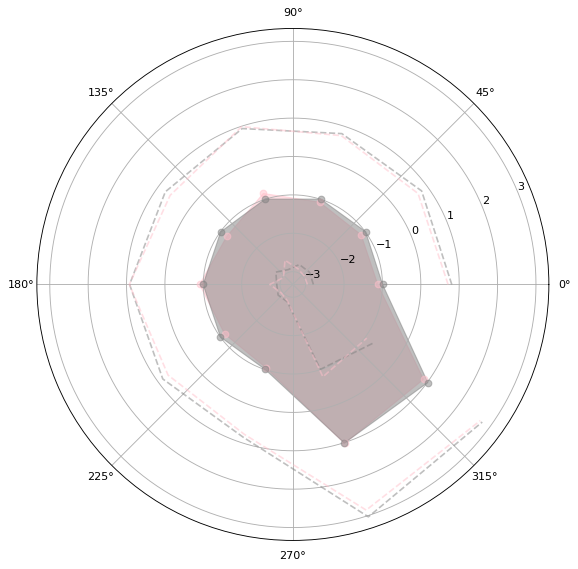

In [ ]:
ax = WindroseAxes.from_ax()
klass = 1
means_tr = np.mean(samp_x[result[-4] == klass],axis = 0)
means_te = np.mean(data[-2][data[-1] == klass],axis = 0)
print("trenn on keskmiselt laiem kui test %s võrra" %(sum(means_tr - means_te)))
means_tr = np.mean(samp_x[result[-4] == klass],axis = 0)
dirs = np.linspace(0,360,dim+1)[:-1]
means_te =np.mean(data[-2][data[-1] == klass],axis = 0) 
std_tr = np.std(data[-2][data[-1] == klass],axis = 0) 
std_te = np.std(samp_x[result[-4] == klass],axis = 0)
#print(means)
#ax.bar(dirs, means, normed=True, opening=1.8, edgecolor='white')
ax.fill(np.radians(dirs), means_tr,alpha = 0.5, color = "pink")
ax.fill(np.radians(dirs), means_te,alpha = 0.5, color = "grey")
ax.plot(np.radians(dirs), means_te + std_te,alpha = 0.5,linestyle = "--", color = "grey")
ax.plot(np.radians(dirs), means_te - std_te,alpha = 0.5,linestyle = "--", color = "grey")
ax.plot(np.radians(dirs), means_tr + std_tr,alpha = 0.5,linestyle = "--", color = "pink")
ax.plot(np.radians(dirs), means_tr - std_tr,alpha = 0.5,linestyle = "--", color = "pink")

ax.plot(np.radians(dirs), means_tr, "o",alpha = 0.5, color = "pink")
ax.plot(np.radians(dirs), means_te, "o",alpha = 0.5, color = "grey")
plt.savefig(path + "NN_roos_%s_%s.png" % (test, klass))


In [ ]:
jaot0 = result[-6][-1][result[-4] == 0]
jaot1 =  result[-6][-1][result[-4] == 1]
jaot0.T[0] -= 5
jaot1.T[0] += 5

jaot = np.concatenate((jaot0,jaot1))
get_jaotus([jaot],-1,result[-4],"kokkusurutud tr. andmetel","tr_kokku_100" , True, a, b, 50)


In [ ]:
temperature_7 = cal_methods_slim.TemperatureScaling()
temperature_7.fit(jaot, result[-4])

In [ ]:
probs =  softmax(jaot.T,1)
rel_diag(25 ,probs, result[-4], title_save= "rel_tr_spec_%s" % (test))

In [ ]:
_, bins = np.histogram((result[-5][-1].T[1] - result[-5][-1].T[0]),100, density = True)
vahe1, _ = np.histogram((result[-5][-1].T[1] - result[-5][-1].T[0])[data[-1] == 1],bins, density = True)
vahe0, _  = np.histogram((result[-5][-1].T[1] - result[-5][-1].T[0])[data[-1] == 0],bins, density = True)


jaotus = vahe1/(vahe1 + vahe0)
plt.plot( bins[1:],jaotus, label = "pos. klassi tõen. jaotus", color = "purple")
vahe1, _ = np.histogram((result[-2][-1].T[1] - result[-2][-1].T[0])[data[-1] == 1],bins, density = True)
vahe0, _  = np.histogram((result[-2][-1].T[1] - result[-2][-1].T[0])[data[-1] == 0],bins, density = True)


jaotus = vahe1/(vahe1 + vahe0)
plt.title("Positiivse klassi skooride jaotuse ja sigmoidi suhe \n sõltuvalt kalibratsioonist; $T = %s$"%(np.round(result[2][-1],2)))
#plt.plot(bins[1:], jaotus, color = "purple", label = "pos. klassi kalib. tõen. jaotus",ls = "--",)

plt.plot(bins[1:],sigmoid(bins[1:]),label = "$\sigma(z)$", color = "orange")
plt.plot(bins[1:],sigmoid(bins[1:]/res[-1]), label = "$\sigma(z/T)$", color = "orange",ls = "--",)
#plt.plot(bins[1:],sigmoid(set_1[-5][-1].T[1] - set_1[-5][-1].T[0]),25, cumulative = True,histtype = "step", density = True, label = "test")
plt.xlabel("skoor")
plt.ylabel("$P(X=1)$")
plt.legend()
plt.savefig(path + "sig_ala1_2.png", dpi  =300)


In [ ]:
_, bins = np.histogram((result[-6][-1].T[1] - result[-6][-1].T[0]),100, density = True)
vahe1, _ = np.histogram((result[-6][-1].T[1] - result[-6][-1].T[0])[result[-4] == 1],bins, density = True)
vahe0, _  = np.histogram((result[-6][-1].T[1] - result[-6][-1].T[0])[result[-4] == 0],bins, density = True)


jaotus = vahe1/(vahe1 + vahe0)
plt.plot( bins[1:],jaotus, label = "pos. klassi tõen. jaotus", color = "purple")
vahe1, _ = np.histogram((result[-6][-1].T[1]/tr_t - result[-6][-1].T[0]/tr_t)[result[-4] == 1],bins, density = True)
vahe0, _  = np.histogram((result[-6][-1].T[1]/tr_t - result[-6][-1].T[0]/tr_t)[result[-4] == 0],bins, density = True)


jaotus = vahe1/(vahe1 + vahe0)
plt.title("Positiivse klassi skooride jaotuse ja sigmoidi suhe \n sõltuvalt kalibratsioonist; $T = %s$"%(np.round(result[-3][-1],2)))
plt.plot(bins[1:], jaotus, color = "purple", label = "pos. klassi kalib. tõen. jaotus",ls = "--",)

plt.plot(bins[1:],sigmoid(bins[1:]),label = "$\sigma(z)$", color = "orange", alpha = 0.5)
plt.plot(bins[1:],sigmoid(bins[1:]/tr_t), label = "$\sigma(z/T)$", color = "orange",ls = "--",)
#plt.plot(bins[1:],sigmoid(set_1[-5][-1].T[1] - set_1[-5][-1].T[0]),25, cumulative = True,histtype = "step", density = True, label = "test")
plt.xlabel("skoor")
plt.ylabel("$P(X=1)$")
plt.legend()
plt.savefig(path + "sig_ala4_1.png", dpi  =300)


In [ ]:
probs =  softmax(result[-6][-1].T, 0.55)
rel_diag(25 ,probs, result[-4], title_save= "rel_tr_ca_%s" % (test))

In [ ]:
#probs =  sigmoid(result[-5][-1])
probs = softmax(result[-5][-1].T,1)
rel_diag(25 ,probs, data[-1],title_save= "rel_te_%s" % (test))

In [ ]:

#probs =  sigmoid(result[-2][-1])
probs = softmax(result[-2][-1].T,1)
rel_diag(25 ,probs, data[-1], title_save= "rel_te_ca_%s" % (test))